In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
from string import punctuation
import numpy as np
import pandas as pd
import spacy; nlp = spacy.load('en_core_web_sm')
import torch
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Fake.csv')

In [5]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df.shape

(23481, 4)

In [7]:
df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

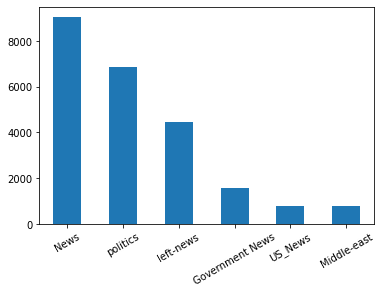

In [8]:
df['subject'].value_counts().plot.bar(rot=30)

In [22]:
print('Среднее количество символов:', df['text'].apply(len).mean())
print('Среднее количество токенов:', df['text'].apply(lambda x: len(x.split())).mean())

Среднее количество символов: 2547.396235254035
Среднее количество токенов: 423.1979046888974


**Препроцессинг**

In [10]:
df['all_text'] = df['title'] + ' ' + df['text']
df['subject'] = pd.Categorical(df['subject'])
df['category'] = df['subject'].cat.codes

In [11]:
X = df['all_text']
y = df['category']

In [12]:
pretrained = ('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin')
w2v_model = KeyedVectors.load_word2vec_format(pretrained, binary=True)
w2v_model.vectors = w2v_model.vectors.astype(np.half)

In [13]:
def preprocessing(text: str):
    doc = nlp(text)
    return [token.lemma_ for token in doc if (
        token.pos_ != 'PUNCT' and token.pos_ != 'NUM')]

In [14]:
model_vocab = w2v_model.key_to_index
unk = w2v_model.key_to_index['UNK']

maxlen = 256
dim = 300

X_vec = np.zeros((len(X), maxlen, dim), dtype=np.half)
for i, text in tqdm(enumerate(X), total=len(X)):
    text_lemm = preprocessing(text)
    for j, lemm in enumerate(text_lemm):
        if j == maxlen:
            break
        X_vec[i, j] = w2v_model[model_vocab.get(lemm, unk)]
        
X_vec = torch.from_numpy(X_vec)
torch.save(X_vec, 'X_vec.pt')

  0%|          | 0/23481 [00:00<?, ?it/s]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.33, random_state=42)

In [16]:
ytr, yte = train_test_split(df["category"], test_size=0.33, random_state=42)

torch.save(X_train, 'X_train.pt')
torch.save(X_test, 'X_test.pt')
torch.save(torch.from_numpy(ytr.to_numpy()), "y_train.pt")
torch.save(torch.from_numpy(yte.to_numpy()), "y_test.pt")

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
print('Видеокарта:', torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Видеокарта: False


In [19]:
target_classes = set(df['subject'])
emb_len = 256

In [20]:
class CLSTM_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.loss = 'categorical_crossentropy'
        self.optimizer = 'adam'
        self.l1_reg = 0
        self.l2_reg = 3
        
        self.hidden_dim = 100
        self.num_layers = 3
        self.embed_dim = 300
        self.class_num = 6
        self.emb_len = 256
        self.kernel_size = 3

        # CNN
        self.conv = nn.Conv1d(self.emb_len, self.embed_dim, self.kernel_size, stride=1)

        # LSTM
        self.lstm = nn.LSTM(self.embed_dim - 2, self.hidden_dim, 
                            num_layers=self.num_layers, dropout = 0.1)

        # linear
        self.hidden2label1 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.hidden2label2 = nn.Linear(self.hidden_dim // 2, self.class_num)
        # dropout
        self.dropout = nn.Dropout(args.dropout)
        
        
    def forward(self, x):
        # CNN
        cnn_x = F.relu(self.conv(x))
        cnn_x = torch.flatten(cnn_x, 1)
        
        # LSTM
        lstm_out, _ = self.lstm(cnn_x)
        lstm_out = torch.transpose(lstm_out, 0, 1)
        lstm_out = torch.transpose(lstm_out, 1, 2)
        lstm_out = F.max_pool1d(lstm_out, lstm_out.size(2)).squeeze(2)
        
        # linear
        cnn_lstm_out = self.hidden2label1(F.relu(lstm_out))
        cnn_lstm_out = self.hidden2label2(F.relu(cnn_lstm_out))
        
        # output
        logit = cnn_lstm_out
        return logit


clstm = CLSTM_classifier()